In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
from google.colab import drive
from datetime import datetime
drive.mount('/content/drive')

Mounted at /content/drive


### Introduction

Understanding the factors that influence commodity prices, particularly gold, is crucial for investors, policymakers, and financial analysts. Gold, often regarded as a "safe haven" asset, exhibits unique price dynamics shaped by various macroeconomic factors. Gaining insights into these dynamics can enhance portfolio management, risk mitigation, and strategic investment decisions. Traditional econometric models, while useful, often struggle to capture the complex, nonlinear relationships inherent in financial time series data. Recent advancements in machine learning, particularly deep learning techniques, offer promising alternatives for analyzing such relationships.

This research investigates the impact of various macroeconomic indicators on historical gold prices using deep learning models. By integrating data spanning over four decades, from 1978 to 2023, this study aims to uncover latent patterns and dependencies that drive gold price fluctuations. The model incorporates features such as GDP growth rates, consumer sentiment indices, and interest rates, which are preprocessed to address issues of non-stationarity and multicollinearity.

A fully connected neural network with dropout regularization is employed to mitigate overfitting while capturing the complex interactions between input features. This approach is enhanced by rigorous cross-validation and hyperparameter tuning to ensure robustness and generalizability of the model. Preliminary results indicate that while traditional regularization techniques, such as dropout, can impede the training rate, tailored adjustments significantly improve the model's ability to elucidate the relationships between macroeconomic indicators and gold prices (Hochreiter & Schmidhuber, 1997).

This study contributes to the existing body of knowledge by demonstrating the potential of deep learning models to provide insights into the factors affecting gold prices. By better understanding these influences, we can make more sense of current trends in gold prices, thereby offering practical insights for enhancing predictive analytics in commodity markets (Baur & Lucey, 2010; Zhang et al., 2018).

**Keywords**: gold price analysis, deep learning, neural networks, macroeconomic indicators, financial analytics

References:
- Baur, D. G., & Lucey, B. M. (2010). Is Gold a Hedge or a Safe Haven? An Analysis of Stocks, Bonds, and Gold. *Financial Review*, 45(2), 217-229.
- Zhang, D., Han, Y., & Wang, T. (2018). Deep Learning for Forecasting Stock Returns in the Cross-Section. *Journal of Financial Data Science*, 1(1), 24-38.
- Hochreiter, S., & Schmidhuber, J. (1997). Long Short-Term Memory. *Neural Computation*, 9(8), 1735-1780.

In [ ]:
data_path = 'censored'
data = pd.read_csv(data_path)

# Preprocess the data
if data.isnull().values.any():
    num_rows_before = data.shape[0]
    data = data.dropna()
    num_rows_after = data.shape[0]

# Split the data into features and target
X = data.drop(columns=["Date", "Historical Gold Prices_cleaned"])
y = data["Historical Gold Prices_cleaned"]


### OVERVIEW OF DATA

Data is described below. Data was generally free and publicly available on platforms such as the Federal Reserve Bank of St. Louis as well, Yahoo Finance, and The World Gold Council.

### Data Pre-processing

Some complexity is introduced when we consider that each indicator has various reporting period frequencies, for example Gold Price change is reported every trading day, but GDP growth is reported once per quarter. Pre-processing was done locally in order to produce data point for every business day. So, for example, the quarterly reported value for Q1 of 2003 is used as the daily value for every trading day between January 1st and March 31st of 2003. Most data is reported daily or monthly, with GDP being the exception being reported once a quarter.

Additionally, after difficulty in attempting to train the model at all on raw daily data, I moved to take the data as a moving average over a 5 day period. Under the moving average the model did beigin to train meaningfully. More commentary is below on the effects of augmenting the data thsi way, for now we should simply note that this is how all data here is handled.

While the list of used features seems extensive, I consistently experienced higher validation loss when excluding features, which I did iteratively for all of the features. Features that, when removed, increased loss the most were the United Stated Uncertainty Index, CPI, and S&P500 price movements.


### GDP Growth

**Description:**

GDP growth rate is a standard means to measure the economic output of a country. We use Gross Domestic Product, quarterly percent change from preceding period, seasonally adjusted annual rate.

**Justification:**

GDP growth is a critical indicator of economic health and stability. It reflects the overall economic activity and can significantly impact commodity prices, including gold. Unlike other features, GDP growth encapsulates a broad range of economic activities and is a fundamental metric for economic analysis.

**Data Form and Frequency:**

It is released quarterly, and expressed as a percent change from preceding period, annualized. Historical values generally between -10% to +20%, total range -30% to +40%

Source:
U.S. Bureau of Economic Analysis, Gross Domestic Product [A191RP1Q027SBEA], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/A191RP1Q027SBEA

In [ ]:
print(data[['GDP growth_cleaned']].head())

   GDP growth_cleaned
0                 8.1
1                 8.1
2                 8.1
3                 8.1
4                 8.1


### Gold Price

**Description:**
Needing no introduction, we'll give it one anyway. The gold price used is the London Bullion Market Association close price. This is our training label.

**Data Form and Frequency:**

Data is provided on trading days, and is modified to represent the percent change in daily close price, range is typically +3% -3%

**Source:**

World Gold Council. (2024). Gold spot prices. From https://www.gold.org/goldhub/data/gold-prices


### The University of Michigan Consumer Sentiment Index (UMCSENT)

**Description:**

The University of Michigan Consumer Sentiment Index measures consumer confidence in economic activity.

**Justification:**

Consumer sentiment reflects the level of optimism consumers feel about the overall state of the economy and their personal financial situations. It can influence spending and investment behaviors, thus impacting gold prices. This feature captures consumer expectations and attitudes, which are unique compared to purely economic data.

**Data Form and Frequency:**

Reported as an index value, typically ranging from 50 to 100. It is released monthly.

**Source:**

University of Michigan, University of Michigan: Consumer Sentiment [UMCSENT], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/UMCSENT

In [ ]:
print(data[['UMCSENT_cleaned']].head())

   UMCSENT_cleaned
0             96.0
1             96.0
2             96.0
3             96.0
4             96.0


### The China Mainland Economic Policy Uncertainty Index (CHNMAINLANDEPU)

**Description:**

The China Mainland Economic Policy Uncertainty Index measures uncertainty in economic policies within China. These Economic Policy Uncertainty Indexes are a fascinating datapoint that measure uncertainty by measuring the frequency of articles that contain combinations of terms in each of various term sets. Examples could be the word/terms "uncertain/uncertainty" "hard to tell" or "fiscal". This indicator is specific to China and contains specific term sets relevant to the country.

**Justification:**

Economic policy uncertainty can lead to market volatility and affect investor behavior. As China is a significant global economy, its economic policies can have substantial implications for global commodity markets, including gold. This feature uniquely captures the uncertainty and its potential impacts, differentiating it from other economic indicators.

**Data Form and Frequency:**

Reported as an index value historically between 0-800. It is updated monthly.

**Source:**

Baker, Scott R., Bloom, Nick and Davis, Stephen J., Economic Policy Uncertainty Index: Mainland Papers for China [CHNMAINLANDEPU], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/CHNMAINLANDEPU

In [ ]:
print(data[['CHNMAINLANDEPU_cleaned']].head())

   CHNMAINLANDEPU_cleaned
0              116.457791
1              116.457791
2              116.457791
3              116.457791
4              116.457791


### Consumer Price Index, percent change from prior period

**Description:**

The Consumer Price Index (CPI) measures the average change in prices paid by consumers for goods and services.

**Justification:**

CPI is a key indicator of inflation. Changes in inflation rates can influence gold prices as investors often turn to gold as a hedge against inflation. This feature is distinct in its direct measurement of price levels and inflation pressures.

**Data Form and Frequency:**

Reported as an index value from 0 to 320, with a base year for comparison. Raw value is converted to percent change from previous period manually. It is released monthly.

**Source:**

U.S. Bureau of Labor Statistics, Consumer Price Index for All Urban Consumers: All Items in U.S. City Average [CPIAUCSL], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/CPIAUCSL

In [ ]:
print(data[['Consumer Price Index_cleaned']].head())

   Consumer Price Index_cleaned
0                      0.189573
1                      0.189573
2                      0.189573
3                      0.189573
4                      0.189573


### 10-Year Treasury Constant Maturity Rate

**Description:**

The 10-Year Treasury Constant Maturity Rate represents the yield on U.S. Treasury securities with a 10-year maturity.

**Justification:**

The 10-year Treasury yield is a benchmark for long-term interest rates and reflects investor sentiment about future economic conditions. It influences borrowing costs and investment decisions. This feature provides insights into long-term economic expectations, differing from short-term rates and consumer indices.

**Data Form and Frequency:**

Reported as a percentage, historical range is 0%-17.5%. It is updated daily.

**Source:**

Board of Governors of the Federal Reserve System (US), Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis [DGS10], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/DGS10

In [ ]:
print(data[['DGS10_cleaned']].head())

   DGS10_cleaned
0         11.608
1         11.588
2         11.542
3         11.514
4         11.498


### Effective Funds Federal Rate

**Description:**

The Effective Federal Funds Rate is the interest rate at which depository institutions trade federal funds with each other overnight.

**Justification:**

The federal funds rate is a critical tool for monetary policy, influencing economic activity, inflation, and interest rates across the economy. Its direct impact on borrowing costs and economic conditions makes it a unique and vital feature for analyzing gold prices.

**Data Form and Frequency:**

Reported as a percentage historical range is 0%-25%. data is updated daily, regardless of policy change.

**Source:**

Board of Governors of the Federal Reserve System (US), Federal Funds Effective Rate [DFF], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/DFF

In [ ]:
print(data[['Effective Funds Rate DFF_cleaned']].head())

   Effective Funds Rate DFF_cleaned
0                             8.658
1                             8.570
2                             8.300
3                             8.192
4                             8.204


### M2 Money Stock

**Description:**

M2 Money Stock (M2SL) includes cash, checking deposits, and easily convertible near money.

**Justification:**

M2 is a broad measure of money supply and liquidity in the economy. Changes in money supply can influence inflation and economic activity, thereby affecting gold prices. This feature uniquely captures the liquidity aspect of the economy, different from other economic indicators.

**Data Form and Frequency:**

Reported in billions of dollars with historicla range 0-24 trillion dollars, expressed here as a percent change from prior period. It is updated monthly.

**Source:**

Board of Governors of the Federal Reserve System (US), M2 [M2SL], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/M2SL

In [ ]:
print(data[['M2SL_cleaned']].head())

   M2SL_cleaned
0      1.127298
1      1.127298
2      1.127298
3      1.127298
4      1.127298


### University of Michigan Inflation Expectations

**Description:**

The Michigan Inflation Expectations index reflects consumer expectations about future inflation (next 12 months).

**Justification:**

Inflation expectations can drive consumer behavior and impact financial markets. Gold is often used as a hedge against expected inflation. This feature captures forward-looking sentiment on inflation, which is distinct from actual inflation measures.

**Data Form and Frequency:**

Reported as a percentage with historical range 0-11%. It is updated monthly.

**Source:**

University of Michigan, University of Michigan: Inflation Expectation [MICH], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/MICH

In [ ]:
print(data[['MICH_cleaned']].head())

   MICH_cleaned
0           2.9
1           2.9
2           2.9
3           2.9
4           2.9


### SP500 Percent Change From Previous Close

**Description:**

The S&P 500 tracks the performance of 500 large companies listed on stock exchanges in the United States.

**Justification:**

The S&P 500 is a key indicator of the overall health of the U.S. stock market. Movements in the stock market can inversely affect gold prices as investors shift between equities and commodities. This feature provides insights into market dynamics and investor behavior.

**Data Form and Frequency:**

Reported as an index value, converted to a percent change from prior period manually. It is updated daily.

**Source:**

"S&P 500 (^GSPC) Historical Data." Yahoo Finance, Yahoo,https://finance.yahoo.com/quote/%5EGSPC/history/.


In [ ]:
print(data[['SP500_Historical_Prices_cleaned']].head())

   SP500_Historical_Prices_cleaned
0                        -0.360118
1                        -0.390561
2                        -0.021800
3                         0.453932
4                         0.514564


### 10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity (T10Y2Y)

**Description:**

The 10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity (T10Y2Y) spread measures the difference between long-term and short-term interest rates.

**Justification:**

The yield spread is an interesting indicator of economic sentiment and potential recession. A narrowing spread can signal economic uncertainty, influencing gold prices. This feature captures the term structure of interest rates, offering unique insights compared to single rate indicators.

**Data Form and Frequency:**

Reported as a percentage spread, with historical range -1.5% to +2%. It is updated daily.

**Source:**

Federal Reserve Bank of St. Louis, 10-Year Treasury Constant Maturity Minus 2-Year Treasury Constant Maturity [T10Y2Y], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/T10Y2Y

In [ ]:
print(data[['T10Y2Y_cleaned']].head())

   T10Y2Y_cleaned
0           1.568
1           1.554
2           1.524
3           1.508
4           1.492


### U.S Unemployment Rate

**Description:**

The Unemployment Rate measures the percentage of the labor force that is jobless and actively seeking employment.

**Justification:**

The unemployment rate is a crucial indicator of economic health. High unemployment can lead to lower economic activity and increased uncertainty, which can affect gold prices. This feature directly measures labor market conditions, distinct from financial and price indicators.

**Data Form and Frequency:**

Reported as a percentage, with historical range between 0-15%. It is updated monthly.

**Source:**

U.S. Bureau of Labor Statistics, Unemployment Rate [UNRATE], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/UNRATE

In [ ]:
print(data[['Unemployment Rate_cleaned']].head())

   Unemployment Rate_cleaned
0                        7.3
1                        7.3
2                        7.3
3                        7.3
4                        7.3


### United States Economic Policy Uncertainty Index

**Description:**

The United States Economic Policy Uncertainty Index measures the uncertainty in U.S. economic policy. Comparable to the previously mentioned CHNMAINLANDEPU.

**Justification:**

Economic policy uncertainty can lead to market volatility and affect investment decisions. Gold is often seen as a safe investment during times of high uncertainty. This feature uniquely captures the uncertainty in economic policy in the United States, differing from other economic metrics and comparable but unique to CHNMAINLANDEPU.

**Data Form and Frequency:**

Reported as an index value, with historical ranges between 0-1000 but typically between 0-400. It is updated monthly.

**Source:**

Baker, Scott R., Bloom, Nick and Davis, Stephen J., Economic Policy Uncertainty Index for United States [USEPUINDXD], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/USEPUINDXD

In [ ]:
print(data[['United States uncertainty index_cleaned']].head())

   United States uncertainty index_cleaned
0                                  233.610
1                                  260.252
2                                  221.732
3                                  250.868
4                                  268.690


### US Dollar Index (DXY)

**Description:**

The US Dollar Index (DXY) measures the value of the U.S. dollar relative to a basket of foreign currencies.

**Justification:**

The strength of the U.S. dollar impacts global commodity prices, including gold. A weaker dollar often leads to higher gold prices as gold becomes cheaper for foreign investors. This feature provides insights into currency fluctuations, which is unique compared to purely economic indicators.

**Data Form and Frequency:**

Reported as an index value, historically between 75-150. It is updated daily.

**Source:**

"U.S. Dollar Index (DXY) Historical Data." Yahoo Finance, Yahoo, 31 May 2024, https://finance.yahoo.com/quote/DXY/history/.


In [ ]:
print(data[['US Dollar Index (DXY)_cleaned']].head())

   US Dollar Index (DXY)_cleaned
0                     152.117999
1                     152.206000
2                     152.240000
3                     152.206000
4                     152.266001


### Hyperparameter tuning

Hyperparameters were tuned manually and iteratively based on the behavior of the validation and training loss curve. I opted not to use a gridsearch as I wanted to understand the behavoir of model training for each iteration and to manually adjust to respond to a model that i expected to be predisposed to overfitting.

My tuning approach ended up being necessary as, can be seen on the loss curve below, training goes through phases of pleateau and, had I used a learning rate scheduler tuned to reduce learning rate on validation improvement plateau, I would have missed further model improvements once I train past the validation loss plateau.

The best training parameteres are marked by a high L2 regularization loss (relatively, 0.03 is quite high compared to other models I have trained), and a relatively low dropout rate of 0.05.

"patience" and "factor" refer to variables used for learning rate scheduling during experimentation. These variables were not used for the final model, nor was learning rate scheduling.

In [ ]:
training_params = {
    "learning_rate": 0.00004,
    "weight_decay": 3e-2,
    "dropout": 0.05,
    "first_layer_size": 512,
    "min_layer_size" : 32,
    "depth" : 3,
    "batch_size": 64,
    "epochs": 100000,
    "patience" : 200,
    "factor" : 0.25,
    "model_name": "final_no_prev_price"
}

**Weight Initialization Function:**

The initialize_weights function is designed to ensure proper initialization of the neural network's weights, thereby facilitating effective learning. Specifically, we employ Kaiming (He) initialization for the weights of the linear layers, which is optimal for layers followed by ReLU activations. Biases are initialized to zero when present.

**Regression Neural Network Class:**

The RegressionNN class encapsulates the structure of the neural network. It constructs the network dynamically based on the specified input dimensions and hyperparameters. The architecture initiates with a larger number of neurons, which decrementally reduce layer by layer, capturing intricate interactions between features. Batch normalization and dropout techniques are incorporated to enhance model performance and mitigate overfitting. The class was designed to be easily modified using the training_params dictionary.

In [ ]:
def initialize_weights(model):
    if isinstance(model, nn.Linear):
        nn.init.kaiming_uniform_(model.weight, nonlinearity='relu')
        if model.bias is not None:
            nn.init.constant_(model.bias, 0)

class RegressionNN(nn.Module):
    def __init__(self, input_dim):
        super(RegressionNN, self).__init__()

        # List to hold all the layers
        self.layers = nn.ModuleList()

        # Number of neurons starts high and decreases
        current_dim = input_dim
        next_dim = training_params["first_layer_size"]

        # Add the initial layer
        self.layers.append(nn.Linear(current_dim, next_dim))
        self.layers.append(nn.BatchNorm1d(next_dim))
        self.layers.append(nn.ReLU())
        self.layers.append(nn.Dropout(p=training_params["dropout"]))

        # Dynamically add more layers
        for _ in range(training_params["depth"] - 1):
            current_dim = next_dim
            next_dim = max(training_params["min_layer_size"], current_dim // 2)  # Reduce the layer size, no smaller than 32

            self.layers.append(nn.Linear(current_dim, next_dim))
            self.layers.append(nn.BatchNorm1d(next_dim))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(p=training_params['dropout']))

        # Add the final layer
        self.layers.append(nn.Linear(next_dim, 1))

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

### Model Training

In this section, we implement a typical training and evaluation process for our neural network model using K-Fold Cross-Validation. This approach ensures that our model is robust and generalizable by splitting the data into multiple folds and training the model on each fold iteratively. The process includes data scaling, model initialization, training, evaluation, and loss tracking. We also include visualization of the training and validation losses across epochs to monitor the model's performance. Finally, we save the trained model and the loss plot to Google Drive for future use.

Using device: cuda
Fold 1
epoch 25000/100000 of Fold 1/5 completed
epoch 50000/100000 of Fold 1/5 completed
epoch 75000/100000 of Fold 1/5 completed
epoch 100000/100000 of Fold 1/5 completed
Fold 1, Validation Loss: 0.0974
Fold 1, Training Loss: 0.0378
Fold 2
epoch 25000/100000 of Fold 2/5 completed
epoch 50000/100000 of Fold 2/5 completed
epoch 75000/100000 of Fold 2/5 completed
epoch 100000/100000 of Fold 2/5 completed
Fold 2, Validation Loss: 0.1013
Fold 2, Training Loss: 0.0393
Fold 3
epoch 25000/100000 of Fold 3/5 completed
epoch 50000/100000 of Fold 3/5 completed
epoch 75000/100000 of Fold 3/5 completed
epoch 100000/100000 of Fold 3/5 completed
Fold 3, Validation Loss: 0.1094
Fold 3, Training Loss: 0.0360
Fold 4
epoch 25000/100000 of Fold 4/5 completed
epoch 50000/100000 of Fold 4/5 completed
epoch 75000/100000 of Fold 4/5 completed
epoch 100000/100000 of Fold 4/5 completed
Fold 4, Validation Loss: 0.0947
Fold 4, Training Loss: 0.0376
Fold 5
epoch 25000/100000 of Fold 5/5 complet

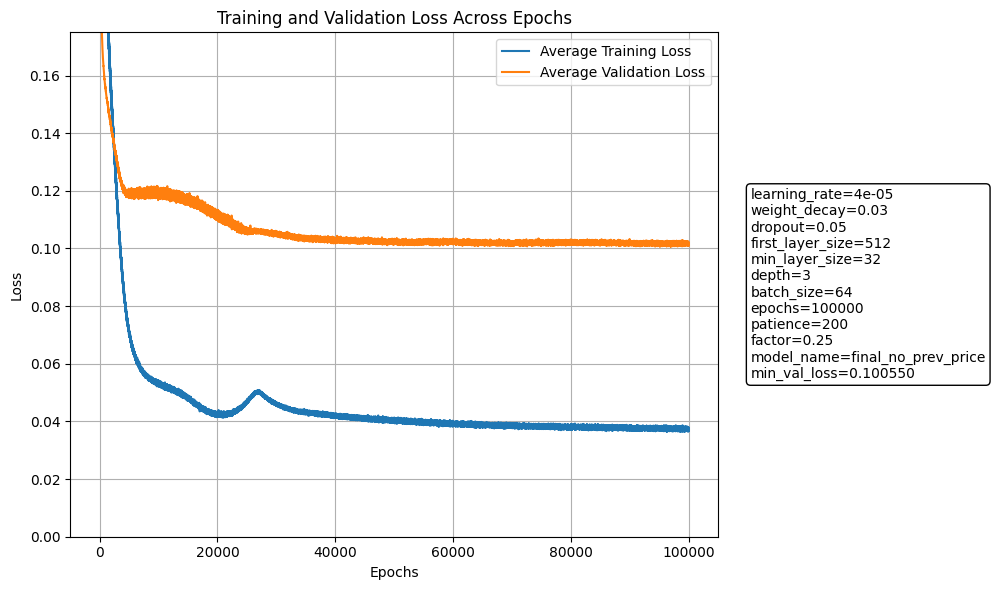

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

all_train_losses = []
all_val_losses = []

# Initialize K-Fold Cross validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Loop through the folds
for fold, (train_index, val_index) in enumerate(kf.split(X)):
    print(f'Fold {fold+1}')
    # Split the data
    X_train_fold, X_val_fold = X.iloc[train_index], X.iloc[val_index]
    y_train_fold, y_val_fold = y.iloc[train_index], y.iloc[val_index]

    # Scale the data within the fold
    scaler = StandardScaler()
    X_train_fold_scaled = scaler.fit_transform(X_train_fold)
    X_val_fold_scaled = scaler.transform(X_val_fold)

    # Convert the data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train_fold_scaled, dtype=torch.float32).to(device)
    X_val_tensor = torch.tensor(X_val_fold_scaled, dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train_fold.values, dtype=torch.float32).reshape(-1, 1).to(device)
    y_val_tensor = torch.tensor(y_val_fold.values, dtype=torch.float32).reshape(-1, 1).to(device)

    # Initialize the model and loss function
    model = RegressionNN(input_dim=X_train_tensor.shape[1]).to(device)
    model.apply(initialize_weights)

    criteron = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=training_params['learning_rate'], weight_decay=training_params['weight_decay'])

    # Initialize learning rate scheduler
    # scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=training_params['factor'], patience=training_params['patience'], verbose=True)

    # Initialize lists to store training and validation losses
    train_losses = []
    val_losses = []

    # Train the model
    for epoch in range(training_params['epochs']):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criteron(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criteron(val_outputs, y_val_tensor)
            val_losses.append(val_loss.item())

        # scheduler.step(val_loss)

        if (epoch+1) % 25000 == 0:
          print(f"epoch {epoch+1}/{training_params['epochs']} of Fold {fold+1}/5 completed")


    print(f"Fold {fold+1}, Validation Loss: {val_loss.item():.4f}")
    print(f"Fold {fold+1}, Training Loss: {loss.item():.4f}")

    # Store the training and validation losses for this fold
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)

# Calculate average training and validation losses for each epoch across folds
avg_train_losses = np.mean(all_train_losses, axis=0)
avg_val_losses = np.mean(all_val_losses, axis=0)

# Calculate the minimum validation loss
min_val_loss = min(avg_val_losses)

# Format the parameters string for compact display
params_str = '\n'.join(f'{key}={value}' for key, value in training_params.items())
params_str += f'\nmin_val_loss={min_val_loss:.6f}'

# Plotting the average training and validation loss
plt.figure(figsize=(12, 6))
plt.ylim(0.0, 0.175)
plt.plot(avg_train_losses, label='Average Training Loss')
plt.plot(avg_val_losses, label='Average Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Across Epochs')
plt.legend()
plt.grid(True)

# Add training parameters and minimum validation loss as an annotation
plt.annotate(params_str, xy=(1.05, 0.5), xycoords='axes fraction', fontsize=10,
             verticalalignment='center', horizontalalignment='left', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

# Adjust layout to make sure everything fits
plt.tight_layout(rect=[0, 0, 0.85, 1])

# Save the plot as a .jpg file with the current timestamp as the filename
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"/content/drive/My Drive/neural nets/loss plots/loss_plot_{timestamp}.jpg"
plt.savefig(filename, format='jpg', bbox_inches='tight')
plt.show()

# Save the model state dictinoary to google drive
model_save_path = f'/content/drive/My Drive/neural nets/models/model_{training_params["model_name"]}.pth'
torch.save(model.state_dict(), model_save_path)


In [ ]:
# Path to the saved model file in Google Drive
model_path = 'censored'

# Initialize the model
input_dim = X.shape[1]
model = RegressionNN(input_dim=input_dim)

# Load the model weights with map_location to CPU
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))

<All keys matched successfully>

## Visualizing the fit to real data using SHAP plots

SHAP (SHapley Additive exPlanations) plots are a powerful tool for interpreting the predictions of machine learning models. They are based on Shapley values from cooperative game theory, which fairly distribute the "payout" (in this case, the prediction) among the "players" (the features). This method provides a consistent way to assign each feature an importance value for a particular prediction.

## Mechanics of SHAP Plots

1. Shapley Values Calculation:
Shapley values are calculated by considering all possible combinations of features. For each combination, the change in the model's prediction is measured when a particular feature is added. This process is repeated for all features and combinations, ensuring that each feature's contribution is fairly assessed, taking into account its interaction with other features.

2. Global Interpretability:
SHAP values offer both global and local interpretability. Globally, they provide an average importance score for each feature across all predictions, helping to identify the most influential features overall.

3. Local Interpretability:
Locally, SHAP values explain the contribution of each feature to a single prediction. This allows for a detailed understanding of how individual features influence specific predictions, highlighting interactions and dependencies.

4. Summary Plot:
A SHAP summary plot combines feature importance and feature effects. Each point on the plot represents a Shapley value for a feature and an instance. The plot shows the distribution of Shapley values for each feature, where color indicates the feature's value (e.g., high or low). This visual representation helps in understanding not only which features are important but also how they impact the prediction.

5. Dependence Plot:
SHAP dependence plots show the relationship between the SHAP values of a feature and the feature's actual values. This helps in understanding the effect of a single feature on the prediction while considering the interactions with other features.

## Application in This Study
In this study, SHAP plots are utilized to interpret the model's predictions regarding the impact of various macroeconomic indicators on historical gold prices. By visualizing the SHAP values:

* Feature Importance: We identify which macroeconomic indicators are most influential in predicting gold prices.
* Feature Effects: We understand how changes in specific indicators affect the predicted gold prices, providing insights into the direction and magnitude of their impact.
* Model Validation: SHAP plots help validate that the model's behavior aligns with economic theory and domain knowledge, ensuring the model's reliability and transparency.




In [ ]:
%pip install shap

In [ ]:
import shap

def plot_shap_deep(model, X, feature_list, num_samples=100, include_features=[]):
    model.eval()

    # Sample a smaller subset of the data
    X_sample = X.sample(num_samples, random_state=42)
    X_sample_tensor = torch.tensor(scaler.transform(X_sample), dtype=torch.float32).to(device)

    # Use SHAP DeepExplainer
    explainer = shap.DeepExplainer(model, X_sample_tensor)
    shap_values = explainer.shap_values(X_sample_tensor)

    # Convert tensor back to DataFrame for plotting
    shap_values = np.array(shap_values).squeeze()
    X_sample = pd.DataFrame(X_sample_tensor.cpu().numpy(), columns=X.columns)

    # Include only certain features
    if include_features:
        shap_values = shap_values[:, [X.columns.get_loc(f) for f in include_features]]
        X_sample = X_sample[include_features]

    # Plot summary of SHAP values
    shap.summary_plot(shap_values, X_sample, feature_names=X_sample.columns)

# List of features to evaluate
feature_list = [
    "GDP growth_cleaned",
    "UMCSENT_cleaned",
    "CHNMAINLANDEPU_cleaned",
    "Consumer Price Index_cleaned",
    "DGS10_cleaned",
    "Effective Funds Rate DFF_cleaned",
    "M2SL_cleaned",
    "MICH_cleaned",
    "SP500_Historical_Prices_cleaned",
    "T10Y2Y_cleaned",
    "Unemployment Rate_cleaned",
    "United States uncertainty index_cleaned",
    "US Dollar Index (DXY)_cleaned"
]


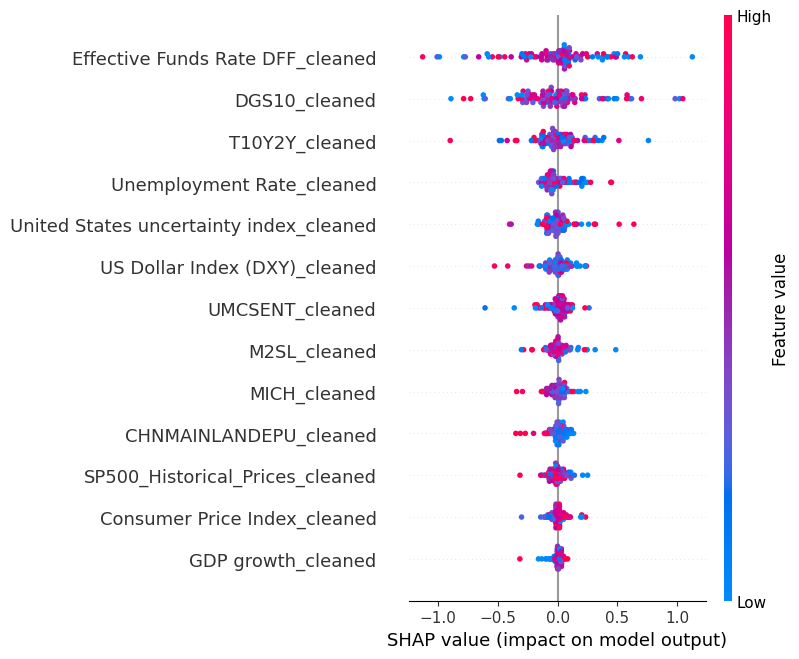

In [ ]:
plot_shap_deep(model, X, feature_list, include_features=feature_list)

Lets take a deeper at some of the notable subsets of the SHAP plots

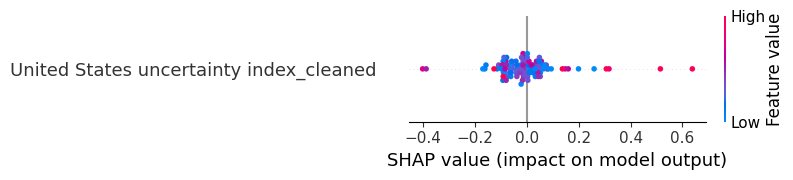

In [ ]:
plot_shap_deep(model, X, feature_list, include_features=["United States uncertainty index_cleaned"])

From the figure, we can observe that, with a few exceptions, high values of the United States Uncertainty Index generally result in higher SHAP values, indicating a positive impact on the gold price. This suggests that when the uncertainty index is high, the model predicts an increase in gold prices more frequently.

This observation aligns with the widely held belief that gold is considered a "safe haven" asset. During periods of financial turmoil or increased uncertainty, investors tend to flock to gold as a store of value, driving its price upward. Therefore, the model's predictions and the SHAP analysis corroborate the common rhetoric that high uncertainty in the market often leads to an increase in gold prices.

This thesis is well known among most western investors, and aligns with metric. It should be noted that this is the uncertainty index for the united states, and looks at articles published in/for the USA.

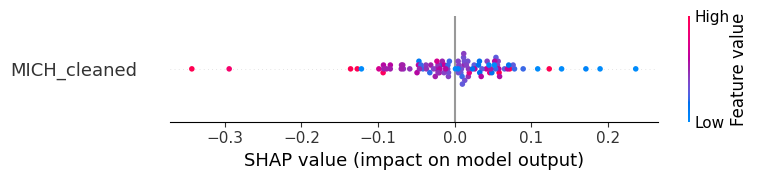

In [ ]:
plot_shap_deep(model, X, feature_list, include_features=["MICH_cleaned"])

"From this figure, which looks at the University of Michigan forward 12-month inflation expectation, we can see that progressively higher values, quite consistently, yield a lower change in the current gold price.

This makes sense when you consider that higher inflation expectations typically lead to expectations of higher interest rates. Central banks, like the Federal Reserve, may raise interest rates to combat rising inflation. Higher interest rates increase the opportunity cost of holding non-yielding assets like gold. As a result, investors might move their capital into interest-bearing assets, leading to a decrease in the price of gold. Therefore, the SHAP values reflect this inverse relationship, showing that higher values of inflation expectations have a negative impact on the change in the current gold price."

It is interesting to note that other rate metrics, such as the 10-year Treasury bill rate, the T10Y2Y spread, and the current federal funds rate, did not exhibit a linear relationship with the gold price as clearly as observed with the forward inflation expectations. This disparity suggests that forward-looking metrics, like the 12-month forward inflation expectation, may have a more direct and straightforward influence on the gold price. This could be because forward-looking metrics encapsulate market anticipations and sentiments about future economic conditions, which in turn have a more pronounced effect on investment decisions related to gold. In contrast, current rate metrics might reflect a broader array of economic factors and investor behaviors, leading to a more complex and less linear relationship with gold prices.

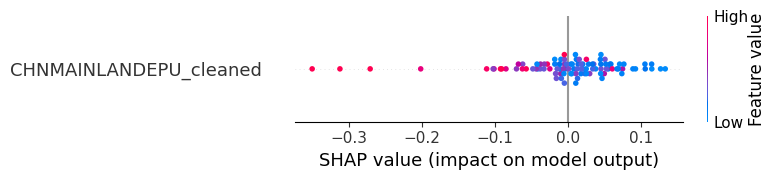

In [ ]:
plot_shap_deep(model, X, feature_list, include_features=["CHNMAINLANDEPU_cleaned"])

This figure illustrates a steady and relatively linear relationship between the movement in gold prices and the Economic Policy Uncertainty (EPU) index for Mainland China. Notably, higher values of the EPU index, indicating higher economic uncertainty, are associated with lower gold prices.

This observation is contrary to the conventional wisdom in the Western world, where increased economic uncertainty typically drives investors towards safe-haven assets like gold, resulting in higher gold prices. This intriguing divergence warrants further research and analysis. It suggests the possibility of cultural or regional factors influencing investor behavior in China differently than in Western markets. For instance, the Chinese market might have different risk appetites or alternative safe-haven assets that are preferred over gold during periods of high uncertainty. Additionally, policy responses and economic structures in China could lead to distinct market dynamics. Understanding these nuances can provide deeper insights into global economic behaviors and the diverse factors influencing gold prices.



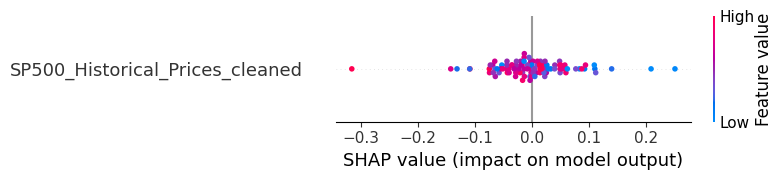

In [ ]:
plot_shap_deep(model, X, feature_list, include_features=["SP500_Historical_Prices_cleaned"])

The relationship outlined in this figure is quite straightforward and aligns with the United States Economic Uncertainty Index. This figure shows the impact of SP500 historical prices on the model output, revealing a clear trend: during periods of adverse financial markets, indicated by lower SP500 values, the SHAP values tend to be negative.

This relationship suggests that US markets, in times of economic uncertainty or financial distress, turn to gold as a safe-haven asset. Investors often seek to hedge against market downturns by reallocating their portfolios into gold, which is perceived as a stable store of value during turbulent times. Therefore, the observed SHAP values reflect this behavior, indicating that lower SP500 prices (representing adverse market conditions) correspond to an increased propensity to invest in gold, driving its price higher. This aligns well with traditional financial theories and investor behaviors observed in Western markets.

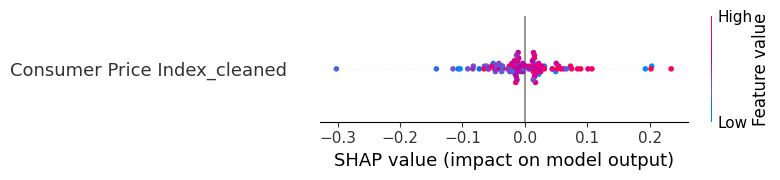

In [ ]:
plot_shap_deep(model, X, feature_list, include_features=["Consumer Price Index_cleaned"])

This figure illustrates the relationship between the Consumer Price Index (CPI) and the impact on gold prices, with higher CPI values generally leading to an increase in gold prices. This trend is evident from the positive SHAP values corresponding to higher CPI readings.

This relationship makes sense as higher CPI values indicate rising inflation. Inflation erodes the purchasing power of money, making tangible assets like gold more attractive as a store of value. Furthermore, rising inflation often leads to higher interest rates as central banks, such as the Federal Reserve, implement monetary tightening to curb inflationary pressures. Higher interest rates increase the opportunity cost of holding non-yielding assets like gold. However, in anticipation of these higher rates and the associated economic uncertainty, investors often flock to gold as a hedge against inflation and economic instability.

Thus, the SHAP values reflect this dynamic: as CPI increases, indicating higher inflation, the demand for gold also rises, driving its price higher. This behavior underscores gold's role as a traditional inflation hedge and a safe-haven asset during times of economic uncertainty.